In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import neighbors
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn import preprocessing
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc, precision_recall_curve, f1_score, precision_score
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from sklearn import cross_validation
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import GaussianNB
from sklearn import linear_model

import numpy as np
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from imblearn.datasets import make_imbalance
df = pd.read_csv('data_for_student_case.csv')
print '\nshape of data'
print df.shape
print '\ntypes of index'
print df.dtypes
print '\ndescribe (only for float data)'
print df.describe()

C:\Users\mitch\Anaconda3\envs\cyberdata2.7\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)



shape of data
(290382, 17)

types of index
txid                              int64
bookingdate                      object
issuercountrycode                object
txvariantcode                    object
bin                             float64
amount                          float64
currencycode                     object
shoppercountrycode               object
shopperinteraction               object
simple_journal                   object
cardverificationcodesupplied     object
cvcresponsecode                   int64
creationdate                     object
accountcode                      object
mail_id                          object
ip_id                            object
card_id                          object
dtype: object

describe (only for float data)
                txid            bin        amount  cvcresponsecode
count  290382.000000  290242.000000  2.903820e+05    290382.000000
mean   279916.750673  485254.586238  2.936462e+04         0.769004
std    138437.214796   37015.

In [2]:
df['bookingdate'] = pd.to_datetime(df['bookingdate'])
df['creationdate'] = pd.to_datetime(df['creationdate'])
currency_dict = {'MXN': 0.01*0.05, 'SEK': 0.01*0.11, 'AUD': 0.01*0.67, 'GBP': 0.01*1.28, 'NZD': 0.01*0.61}
df['euro'] = map(lambda x,y: currency_dict[y]*x, df['amount'],df['currencycode'])
#key = lambda k:k.day
#print df.groupby(df['bookingdate'].apply(key))

In [3]:
df_sort_creation = df.sort_values(by = 'creationdate', ascending = True)#Returns a new dataframe, leaving the original dataframe unchanged
key = lambda k:(k.year,k.month,k.day)
#print df_sort_creation.groupby(df_sort_creation['creationdate'].apply(key)).mean()['amount']

In [4]:
def num_missing(x):
    return sum(x.isnull())

df_renamed = df.rename(index=str, columns = {'txvariantcode': 'cardtype', 'bin': 'issuer_id', 'shopperinteraction': 'shoppingtype',
                   'simple_journal': 'label', 'cardverificationcodesupplied': 'cvcsupply', 
                  'cvcresponsecode': 'cvcresponse', 'accountcode': 'merchant_id'})
df_select = (df_renamed[['issuercountrycode', 'cardtype', 'issuer_id', 'euro', 'currencycode',
              'shoppercountrycode', 'shoppingtype', 'label', 'cvcsupply', 'cvcresponse', 'merchant_id',
              'mail_id', 'ip_id', 'card_id']])
print "Missing values per column:"
print df_select.apply(num_missing, axis=0)
print "Missing values per row:"
#print df_select.apply(num_missing, axis=1).head()
#df_select.shape
#df_clean = df_select.dropna(axis=0)
df_clean = df_select.fillna('missing')

Missing values per column:
issuercountrycode       493
cardtype                  0
issuer_id               140
euro                      0
currencycode              0
shoppercountrycode      482
shoppingtype              0
label                     0
cvcsupply             14717
cvcresponse               0
merchant_id               0
mail_id                   0
ip_id                     0
card_id                   0
dtype: int64
Missing values per row:


In [5]:
issuercountrycode_category = pd.Categorical(df_clean['issuercountrycode'])
cardtype_category = pd.Categorical(df_clean['cardtype'])
#issuer_id_category = pd.Categorical.from_array(df_clean['issuer_id'])
currencycode_category = pd.Categorical(df_clean['currencycode'])
shoppercountrycode_category = pd.Categorical(df_clean['shoppercountrycode'])
shoppingtype_category = pd.Categorical(df_clean['shoppingtype'])
cvcsupply_category = pd.Categorical(df_clean['cvcsupply'])
merchant_id_category = pd.Categorical(df_clean['merchant_id'])
mail_id_category = pd.Categorical(df_clean['mail_id'])
ip_id_category = pd.Categorical(df_clean['ip_id'])
card_id_category = pd.Categorical(df_clean['card_id'])

issuercountrycode_dict = dict(set(zip(issuercountrycode_category, issuercountrycode_category.codes)))
cardtype_dict = dict(set(zip(cardtype_category, cardtype_category.codes)))
currencycode_dict = dict(set(zip(currencycode_category, currencycode_category.codes)))
shoppercountrycode_dict = dict(set(zip(shoppercountrycode_category, shoppercountrycode_category.codes)))
shoppingtype_dict = dict(set(zip(shoppingtype_category, shoppingtype_category.codes)))
cvcsupply_dict = dict(set(zip(cvcsupply_category, cvcsupply_category.codes)))
merchant_id_dict = dict(set(zip(merchant_id_category, merchant_id_category.codes)))
mail_id_dict = dict(set(zip(mail_id_category, mail_id_category.codes)))
ip_id_dict = dict(set(zip(ip_id_category, ip_id_category.codes)))
card_id_dict = dict(set(zip(card_id_category, card_id_category.codes)))

df_clean['issuercountrycode'] = issuercountrycode_category.codes
df_clean['cardtype'] = cardtype_category.codes
df_clean['currencycode'] = currencycode_category.codes
df_clean['shoppercountrycode'] = shoppercountrycode_category.codes
df_clean['shoppingtype'] = shoppingtype_category.codes
df_clean['cvcsupply'] = cvcsupply_category.codes
df_clean['merchant_id'] = merchant_id_category.codes
df_clean['mail_id'] = mail_id_category.codes
df_clean['ip_id'] = ip_id_category.codes
df_clean['card_id'] = card_id_category.codes
df_clean['label_int'], df_clean['cvcresponse_int']= 0,0
df_clean['label_int'] = map(lambda x:1 if str(x) == 'Chargeback' else 0 if str(x) == 'Settled' else 'unknown', df_clean['label'])
df_clean['cvcresponse_int'] = map(lambda x:3 if x > 2 else x+0, df_clean['cvcresponse'])
#0 = Unknown, 1=Match, 2=No Match, 3=Not checked
df1 = df_clean.ix[(df_clean['label_int']==1) | (df_clean['label_int']==0)]#237036 instances
df1.head()

C:\Users\mitch\Anaconda3\envs\cyberdata2.7\lib\site-packages\ipykernel_launcher.py:38: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


,issuercountrycode,cardtype,issuer_id,euro,currencycode,shoppercountrycode,shoppingtype,label,cvcsupply,cvcresponse,merchant_id,mail_id,ip_id,card_id,label_int,cvcresponse_int
0,92,3,530056,32.40,2,103,1,Chargeback,1,0,1,198681,8033,81635,1,0
1,92,3,547046,22.45,2,103,1,Chargeback,1,0,1,921,205937,49763,1,0
2,92,3,528843,74.95,2,103,1,Chargeback,1,0,1,126264,200422,136762,1,0
3,92,3,547146,54.95,2,103,1,Chargeback,1,0,1,183709,9264,78697,1,0
4,92,7,477291,44.95,2,103,1,Chargeback,1,0,1,74828,209046,232186,1,0


In [6]:
df_input = (df1[['issuercountrycode', 'cardtype', 'issuer_id', 'currencycode',
              'shoppercountrycode', 'shoppingtype', 'cvcsupply', 'cvcresponse_int', 'merchant_id', 'euro',
              'label_int']])
df_input[['issuer_id','label_int']] = df_input[['issuer_id','label_int']].astype(int)
print df_input.dtypes
x = df_input[df_input.columns[0:-1]].as_matrix()
y = df_input[df_input.columns[-1]].as_matrix()

issuercountrycode       int16
cardtype                 int8
issuer_id               int32
currencycode             int8
shoppercountrycode      int16
shoppingtype             int8
cvcsupply                int8
cvcresponse_int         int64
merchant_id              int8
euro                  float64
label_int               int32
dtype: object


C:\Users\mitch\Anaconda3\envs\cyberdata2.7\lib\site-packages\pandas\core\frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [8]:
x_array = np.array(x)
min_max_scaler = preprocessing.MinMaxScaler()
X_new = min_max_scaler.fit_transform(x)
x_array = np.reshape(X_new,x.shape)
x_in = x_array;
y_in = y;

print '\nSplitting training and testing data:\n'
x_train, x_test, y_train, y_test = cross_validation.train_test_split(x_in, y_in, test_size = 0.2)#test_size: proportion of train/test data

print "\nApplying SMOTE oversampling to data set ..."

sampler = SMOTE(kind='regular')
sampled_X, sampled_Y = sampler.fit_sample(x_train, y_train)

print "\nDone"



Splitting training and testing data:


Applying SMOTE oversampling to data set ...


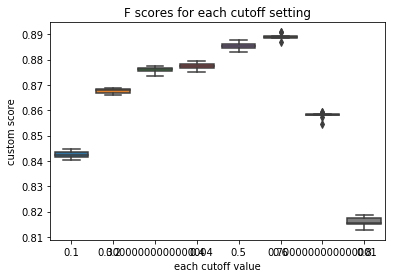

In [10]:
# this part can be used to check the cutoff for non-ranker learners
def cutoff_predict(clf, x, cutoff):
    return (clf.predict_proba(x)[:,1]>cutoff).astype(int)
scores = []

def custom_score(cutoff):
    def score_cutoff(clf, x, y):
        ypred = cutoff_predict(clf, x, cutoff)
        return f1_score(y, ypred)
        #return precision_score(y, ypred)
    return score_cutoff
for cutoff in np.arange(0.1, 0.9, 0.1):
    clf = LogisticRegression()
    validated = cross_validation.cross_val_score(clf, sampled_X , sampled_Y, cv = 10, scoring = custom_score(cutoff))
    scores.append(validated)
sns.boxplot(np.arange(0.1, 0.9, 0.1), scores)
plt.title('F scores for each cutoff setting')
plt.xlabel('each cutoff value')
plt.ylabel('custom score')
plt.show()


Applying SMOTE oversampling to data set ...

Done
after SMOTE sampler


sampled_X size
4260420
sampled_Y size
426042



Applying SMOTE oversampling to data set ...

Done
after SMOTE sampler


sampled_X size
4260440
sampled_Y size
426044



Applying SMOTE oversampling to data set ...

Done
after SMOTE sampler


sampled_X size
4260440
sampled_Y size
426044



Applying SMOTE oversampling to data set ...

Done
after SMOTE sampler


sampled_X size
4260440
sampled_Y size
426044



Applying SMOTE oversampling to data set ...

Done
after SMOTE sampler


sampled_X size
4260440
sampled_Y size
426044



Applying SMOTE oversampling to data set ...

Done
after SMOTE sampler


sampled_X size
4260440
sampled_Y size
426044



Applying SMOTE oversampling to data set ...

Done
after SMOTE sampler


sampled_X size
4260440
sampled_Y size
426044



Applying SMOTE oversampling to data set ...

Done
after SMOTE sampler


sampled_X size
4260440
sampled_Y size
426044



Applying SMOTE oversampling to data set

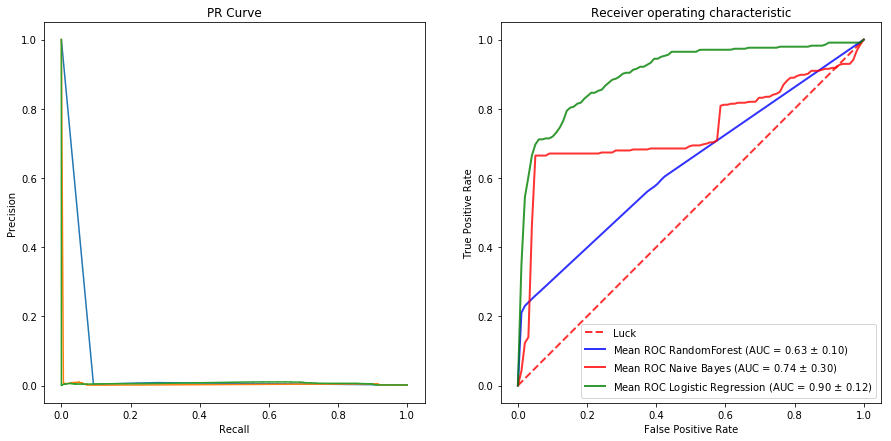

In [12]:
cv = StratifiedKFold(n_splits=10)
clf1 = RandomForestClassifier(n_estimators=50, criterion='gini')
clf2 = GaussianNB()
clf3 = LogisticRegression()
from scipy import interp
tprs1 = []
aucs1 = []
tprs2 = []
aucs2 = []
tprs3 = []
aucs3 = []
y_real = []
y_proba1 = []
y_proba2 = []
y_proba3 = []
mean_fpr = np.linspace(0, 1, 100)
TP1, TP2, TP3, FP1, FP2, FP3, TN1, TN2, TN3, FN1, FN2, FN3 = 0, 0, 0, 0, 0 ,0 ,0 ,0 ,0 ,0 ,0 ,0
cutoff = 0.5 # 0.6 for logistic regression

for train, test in cv.split(x_in, y_in):
    x_train, x_test, y_train, y_test = x_in[train], x_in[test], y_in[train], y_in[test]
    
    print "\nApplying SMOTE oversampling to data set ..."

    sampler = SMOTE(kind='regular')
    sampled_X, sampled_Y = sampler.fit_sample(x_train, y_train)

    print "\nDone"

    print 'after SMOTE sampler'
    print '\n'
    print 'sampled_X size'
    print sampled_X.size
    print 'sampled_Y size'
    print sampled_Y.size
    print '\n' 
    y_real.append(y_test)
    probas_ = clf1.fit(x_train, y_train).predict_proba(x_test)
    # Compute ROC curve and area the curve
    y_predict1 = (probas_[:,1]>cutoff).astype(int)
    fpr1, tpr1, thresholds1 = roc_curve(y[test], probas_[:, 1])
    tprs1.append(interp(mean_fpr, fpr1, tpr1))
    tprs1[-1][0] = 0.0
    roc_auc = auc(fpr1, tpr1)
    aucs1.append(roc_auc)
    y_proba1.append(probas_[:,1])
    probas_ = clf2.fit(sampled_X, sampled_Y).predict_proba(x_test)
    y_predict2 = (probas_[:,1]>cutoff).astype(int)
    # Compute ROC curve and area the curve
    fpr2, tpr2, thresholds1 = roc_curve(y[test], probas_[:, 1])
    tprs2.append(interp(mean_fpr, fpr2, tpr2))
    tprs2[-1][0] = 0.0
    roc_auc = auc(fpr2, tpr2)
    aucs2.append(roc_auc)
    y_proba2.append(probas_[:,1])
    probas_ = clf3.fit(sampled_X, sampled_Y).predict_proba(x_test)
    y_predict3 = (probas_[:,1]>0.6).astype(int)
    # Compute ROC curve and area the curve
    fpr3, tpr3, thresholds3 = roc_curve(y[test], probas_[:, 1])
    tprs3.append(interp(mean_fpr, fpr3, tpr3))
    tprs3[-1][0] = 0.0
    roc_auc = auc(fpr3, tpr3)
    aucs3.append(roc_auc)
    y_proba3.append(probas_[:,1])
    for i in xrange(len(y_predict1)):
        if y_test[i]==1 and y_predict1[i]==1:
            TP1 += 1
        if y_test[i]==0 and y_predict1[i]==1:
            FP1 += 1
        if y_test[i]==1 and y_predict1[i]==0:
            FN1 += 1
        if y_test[i]==0 and y_predict1[i]==0:
            TN1 += 1
        
    for i in xrange(len(y_predict2)):
        if y_test[i]==1 and y_predict2[i]==1:
            TP2 += 1
        if y_test[i]==0 and y_predict2[i]==1:
            FP2 += 1
        if y_test[i]==1 and y_predict2[i]==0:
            FN2 += 1
        if y_test[i]==0 and y_predict2[i]==0:
            TN2 += 1

    for i in xrange(len(y_predict3)):
        if y_test[i]==1 and y_predict3[i]==1:
            TP3 += 1
        if y_test[i]==0 and y_predict3[i]==1:
            FP3 += 1
        if y_test[i]==1 and y_predict3[i]==0:
            FN3 += 1
        if y_test[i]==0 and y_predict3[i]==0:
            TN3 += 1
    
plt.rcParams["figure.figsize"] = (15,7)

y_real = np.concatenate(y_real)
y_proba1 = np.concatenate(y_proba1)
y_proba2 = np.concatenate(y_proba2)
y_proba3 = np.concatenate(y_proba3)

precision1, recall1, _ = precision_recall_curve(y_real, y_proba1)
precision2, recall2, _ = precision_recall_curve(y_real, y_proba2)
precision3, recall3, _ = precision_recall_curve(y_real, y_proba3)
plt.subplot(1, 2, 1)
plt.plot(recall1, precision1 , label='RandomForest')
plt.plot(recall2, precision2, label='NaiveBayes')
plt.plot(recall3, precision3, label='LogisticRegression')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR Curve')

plt.subplot(1, 2, 2)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Luck', alpha=.8)

mean_tpr = np.mean(tprs1, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs1)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC RandomForest (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

mean_tpr = np.mean(tprs2, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs2)
plt.plot(mean_fpr, mean_tpr, color='r',
         label=r'Mean ROC Naive Bayes (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

mean_tpr = np.mean(tprs3, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs3)
plt.plot(mean_fpr, mean_tpr, color='g',
         label=r'Mean ROC Logistic Regression (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

# std_tpr = np.std(tprs, axis=0)
# tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
# tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
# plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
#                  label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

plt.savefig("mysmoteversion.png")
print 'TP: '+ str(TP1)
print 'FP: '+ str(FP1)
print 'FN: '+ str(FN1)
print 'TN: '+ str(TN1)

print 'TP: '+ str(TP2)
print 'FP: '+ str(FP2)
print 'FN: '+ str(FN2)
print 'TN: '+ str(TN2)

print 'TP: '+ str(TP3)
print 'FP: '+ str(FP3)
print 'FN: '+ str(FN3)
print 'TN: '+ str(TN3)